In [1]:
# import dgl # huggingface 같은 라이브러리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lib import Trainer, RNNTrainer
from lib import save_figure_predict
from lib import matplotlib_plot_font
# from models import LSTM
from lib import compute_metrics
from model_select import model_selection

import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from math import ceil
import warnings
warnings.filterwarnings('ignore')

matplotlib_plot_font(KOR=True)
device = torch.device("cpu")

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


In [2]:
import numpy as np
def seq_data(data,sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length):
        x_seq.append(data[i:i+sequence_length])
        y_seq.append(data[i+sequence_length])
        # print(y_seq)
    return x_seq, y_seq #torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)
    
def seed_everything(seed = 42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()


def multi_ahead_prediction(model, scaler, x_test_seq, y_test_seq, horizon):
    x_test = x_test_seq[0]
    gt, pred = [], []
    # print(x_test_seq)
    y_pred = model.predict([x_test])
        
    
    for i in range(horizon):
    
        y_pred = model.predict([x_test[i:]])
        y_pred = scaler.inverse_transform(np.array(y_pred[0]).reshape(1,-1))
        x_test.append(y_pred[0][0])
        y_true = scaler.inverse_transform(np.array(y_test_seq[i]).reshape(1,-1))
        gt.append(y_true[0][0])
        pred.append(y_pred[0][0])
        
    return gt, pred

Seed set = 42


In [3]:
# model = RandomForestRegressor()
# model = GaussianProcessRegressor()
# model.fit(x_train_seq, y_train_seq)

def multi_ahead_prediction(model, scaler, x_test_seq, y_test_seq, horizon):
    x_test = x_test_seq[0]
    gt, pred = [], []
    # print(x_test_seq)
    y_pred = model.predict([x_test])
        
    
    for i in range(horizon):
    
        y_pred = model.predict([x_test[i:]])
        y_pred = scaler.inverse_transform(np.array(y_pred[0]).reshape(1,-1))
        x_test.append(y_pred[0][0])
        y_true = scaler.inverse_transform(np.array(y_test_seq[i]).reshape(1,-1))
        gt.append(y_true[0][0])
        pred.append(y_pred[0][0])
        
    return gt, pred
        
gt, pred = multi_ahead_prediction(model=model, scaler = scaler, x_test_seq = x_test_seq, y_test_seq=y_test_seq, horizon=20)
    
from sklearn.metrics import mean_absolute_error, mean_squared_error

RMSE = mean_squared_error(y_pred=pred, y_true=gt, squared=True)
MAE = mean_absolute_error(y_pred=pred, y_true=gt)

print(RMSE, MAE)
    

NameError: name 'model' is not defined

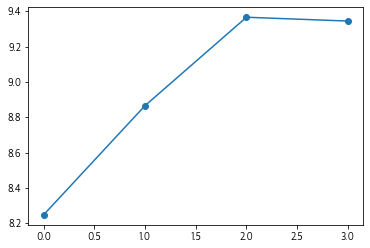

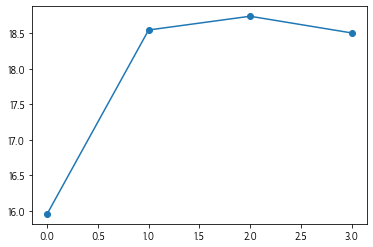

8.24751715531502 8.865337686329045 9.365638402306685 9.344093339692312
15.955569742689145 18.54890502120399 18.742772579566438 18.507641112343368


In [10]:
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.preprocessing import StandardScaler
##################
## Load Dataset ##
##################

region_type = 'city'
df2 = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')

# df = df2.iloc[100:533] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 
df2 = df2.iloc[:850] #340 326 319
df = df2
df = df2.diff()
df = df.dropna()

############################################
## train, test, validation length setting ##
############################################

# split_date = '2020-11-23'
# split_date = '2021-06-25'
split_date = '2021-11-25'
val_ratio = 0.2

train_df = df[df.index < split_date]
test = df.iloc[len(train_df):, :]

len_val = int(train_df.shape[0] * val_ratio)
len_train = train_df.shape[0] - len_val
train = train_df.iloc[:len_train,:]
val = train_df.iloc[len_train :, :]


### 컬럼을 숫자로 바꿔줌 ###
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region
# df.columns = list(region_dict.keys())

y_pred = pd.DataFrame({})
# fig = plt.figure(figsize=(25,15), facecolor='white')
gt_list = []
pred_list = []

############################
## Hyperparameter Setting ##
############################

diff_ = "1st"
suptitle_1 = 'Standard Scaler, LSTM'
epochs = 50
batch_size = 16
num_layers = 1
TIME_STEPS = 5
learning_rate = 1e-2
# criterion = nn.MSELoss()

import shutil
MODEL_NAME = 'GP'
tmp = ""
dataset_name = "RF_test"
horizon = len(test)-TIME_STEPS

result_dir = ('%s'+tmp) % (MODEL_NAME)
model_dir = ('%s'+tmp) % (MODEL_NAME)
Figure_path = os.path.join('Result', dataset_name, 'Figure', str(horizon), result_dir)
Diameter_path = os.path.join('Result', dataset_name, 'Diameter', str(horizon), result_dir)
Pred_path = os.path.join('Result', dataset_name, 'Pred', str(horizon), result_dir)
model_path = os.path.join('Save_model', dataset_name, str(horizon), model_dir)


# if os.path.exists(Figure_path):
#     shutil.rmtree(Figure_path) # 해당 경로 데이터 모두 삭제
# if os.path.exists(Diameter_path):
#     shutil.rmtree(Diameter_path) # 해당 경로 데이터 모두 삭제
# if os.path.exists(Pred_path):
#     shutil.rmtree(Pred_path) # 해당 경로 데이터 모두 삭제
# if os.path.exists(model_path):
#     shutil.rmtree(model_path) # 해당 경로 데이터 모두 삭제
    
os.makedirs(Figure_path, exist_ok=True) # 새로 폴더 생성
os.makedirs(Diameter_path, exist_ok=True) # 새로 폴더 생성
os.makedirs(Pred_path, exist_ok=True) # 새로 폴더 생성
os.makedirs(model_path, exist_ok=True) # 새로 폴더 생성

gt_list, pred_list = pd.DataFrame({}), pd.DataFrame({})
gt_mul_list, pred_mul_list = pd.DataFrame({}), pd.DataFrame({})
MAE_LSTM_list, RMSE_LSTM_list = [], []
# date_split = f"{df.index[0]} ~ {df.index[len_train]} ~ {df.index[len_train + len_val]} ~ {df.index[-1]}"
# print(date_split)
# for i in [0]:
for i, region in enumerate(df.columns):
# for i, region in enumerate(['인천 동구', '경기 시흥시']):
    
    #######################
    ## Define DataLoader ##
    #######################
    
    train = df[[region]][:len_train]
    val = df[[region]][ len_train: len_train + len_val]
    test = df[[region]][ len_train + len_val:]
    
    scaler = StandardScaler()

    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    x_train_seq, y_train_seq = seq_data(train.squeeze().tolist(), TIME_STEPS)
    x_val_seq, y_val_seq = seq_data(val.squeeze().tolist(), TIME_STEPS)
    x_test_seq, y_test_seq = seq_data(test.squeeze().tolist(), TIME_STEPS)
    # print(x_train_seq.shape, x_val_seq.shape, x_test_seq.shape)
    
    date_split = f"{df.index[0]} ~ {df.index[len(x_train_seq)-1]} ~ {df.index[len(x_train_seq)+TIME_STEPS + len(x_val_seq)+TIME_STEPS*2-1]} ~ {df.index[-1]}"
    # print(date_split)
    
    ############################
    ## Define Model and Train ##
    ############################
        
    model = RandomForestRegressor()
    # from sklearn.gaussian_process.kernels import RBF
    # kernel = RBF()
    # model = GaussianProcessRegressor(alpha=1e-2, random_state=2022)
    # model = LGBMRegressor()
                        #   n_estimators=16,
    #                     #   max_depth=100,
    #                     #   num_leaves=50,
    #                     # learning_rate=1e-2  
    #                       random_state=2022)
    model.fit(x_train_seq, y_train_seq#,
            #   eval_set=(x_val_seq, y_val_seq),
            #   early_stopping_rounds=50,
            #   verbose=False
              )
    pred = model.predict(x_test_seq)
    gt_mul, pred_mul = multi_ahead_prediction(model=model, scaler = scaler, x_test_seq = x_test_seq, y_test_seq=y_test_seq, horizon=20)
        
    # from sklearn.metrics import mean_absolute_error, mean_squared_error

    # RMSE = mean_squared_error(y_pred=pred, y_true=gt, squared=True)
    # MAE = mean_absolute_error(y_pred=pred, y_true=gt)

    # print(RMSE, MAE)

    # ground_truth = df2.diff().loc[df[df.index >= split_date].index[TIME_STEPS:TIME_STEPS+horizon]]
    ground_truth = df2.loc[df[df.index >= split_date].index[TIME_STEPS:TIME_STEPS+horizon]]

    gt_list[region] = ground_truth.iloc[:,i].tolist()
    pred_list[region] = list(pred)

    # Metric of each region 
    y_pred[region] = pred
    gt_mul_list[region] = gt_mul
    pred_mul_list[region] = np.array(pred_mul).squeeze() # [[]] -> []
    
    
RMSE, RMSE_total = compute_metrics(gt_list, pred_list, metric='rmse')
MAE, MAE_total = compute_metrics(gt_list, pred_list, metric='mae')

RMSE_5, RMSE_total_5 = compute_metrics(gt_mul_list.iloc[:5], pred_mul_list.iloc[:5], metric='rmse')
MAE_5, MAE_total_5 = compute_metrics(gt_mul_list.iloc[:5], pred_mul_list.iloc[:5], metric='mae')

RMSE_10, RMSE_total_10 = compute_metrics(gt_mul_list.iloc[:10], pred_mul_list.iloc[:10], metric='rmse')
MAE_10, MAE_total_10 = compute_metrics(gt_mul_list.iloc[:10], pred_mul_list.iloc[:10], metric='mae')

RMSE_15, RMSE_total_15 = compute_metrics(gt_mul_list.iloc[:15], pred_mul_list.iloc[:15], metric='rmse')
MAE_15, MAE_total_15 = compute_metrics(gt_mul_list.iloc[:15], pred_mul_list.iloc[:15], metric='mae')

RMSE_20, RMSE_total_20 = compute_metrics(gt_mul_list.iloc[:20], pred_mul_list.iloc[:20], metric='rmse')
MAE_20, MAE_total_20 = compute_metrics(gt_mul_list.iloc[:20], pred_mul_list.iloc[:20], metric='mae')


plt.plot([MAE_total_5, MAE_total_10, MAE_total_15, MAE_total_20], '-o')
plt.show()
plt.plot([RMSE_total_5, RMSE_total_10, RMSE_total_15, RMSE_total_20], '-o')
plt.show()
print(MAE_total_5, MAE_total_10, MAE_total_15, MAE_total_20)
print(RMSE_total_5, RMSE_total_10, RMSE_total_15, RMSE_total_20)
pred_mul_list.to_csv(Pred_path + '/lgbm_predict.csv', encoding='cp949')

In [12]:
#540
pd.DataFrame({'LGBM_MAE' : [2.1691659659595146, 2.718563324700892, 3.057054096831468, 3.2840265588547846],
              'LGBM_RMSE' : [3.9890153177760435, 5.195014158869441, 6.071883039454003, 6.503626482618285],
              'RF_MAE' : [2.608375540316015, 3.574085225741416, 4.007087001316764, 4.289258701898426],
              'RF_RMSE' : [8.747432832933097, 11.623622229757352, 12.594101630031135, 12.877646159235786]}, index=[5, 10, 15, 20]).to_csv('final_result/baseline_540.csv', encoding='cp949')

#707
pd.DataFrame({'LGBM_MAE' : [7.322851043946682, 7.8673458181991345, 8.419999376323656, 8.326557793405637],
              'LGBM_RMSE' : [12.442720576092213, 14.419308959829623, 15.11247173219228, 14.768118136766981],
              'RF_MAE' : [8.24751715531502, 8.865337686329045, 9.365638402306685, 9.344093339692312],
              'RF_RMSE' : [15.955569742689145, 18.54890502120399, 18.742772579566438, 18.507641112343368]}, index=[5, 10, 15, 20]).to_csv('final_result/baseline_707.csv', encoding='cp949')

# LGBM 540
2.1691659659595146 2.718563324700892 3.057054096831468 3.2840265588547846
3.9890153177760435 5.195014158869441 6.071883039454003 6.503626482618285

# RF 540
2.608375540316015 3.574085225741416 4.007087001316764 4.289258701898426
8.747432832933097 11.623622229757352 12.594101630031135 12.877646159235786

# LGBM 707
7.322851043946682 7.8673458181991345 8.419999376323656 8.326557793405637
12.442720576092213 14.419308959829623 15.11247173219228 14.768118136766981

# RF 707
8.24751715531502 8.865337686329045 9.365638402306685 9.344093339692312
15.955569742689145 18.54890502120399 18.742772579566438 18.507641112343368

서류 도장, 신분증

잔금날에 100만원 LH에서 넣어야함.

잔금 지급일도 1월 29일로 협의가

계약서상에 실제로 잔금지급예정일을 1월29일로 기재가 된다면 1월 29일에 잔금지급을 할 예정

받아서 주는거로 해야해서 100을 따로 지급

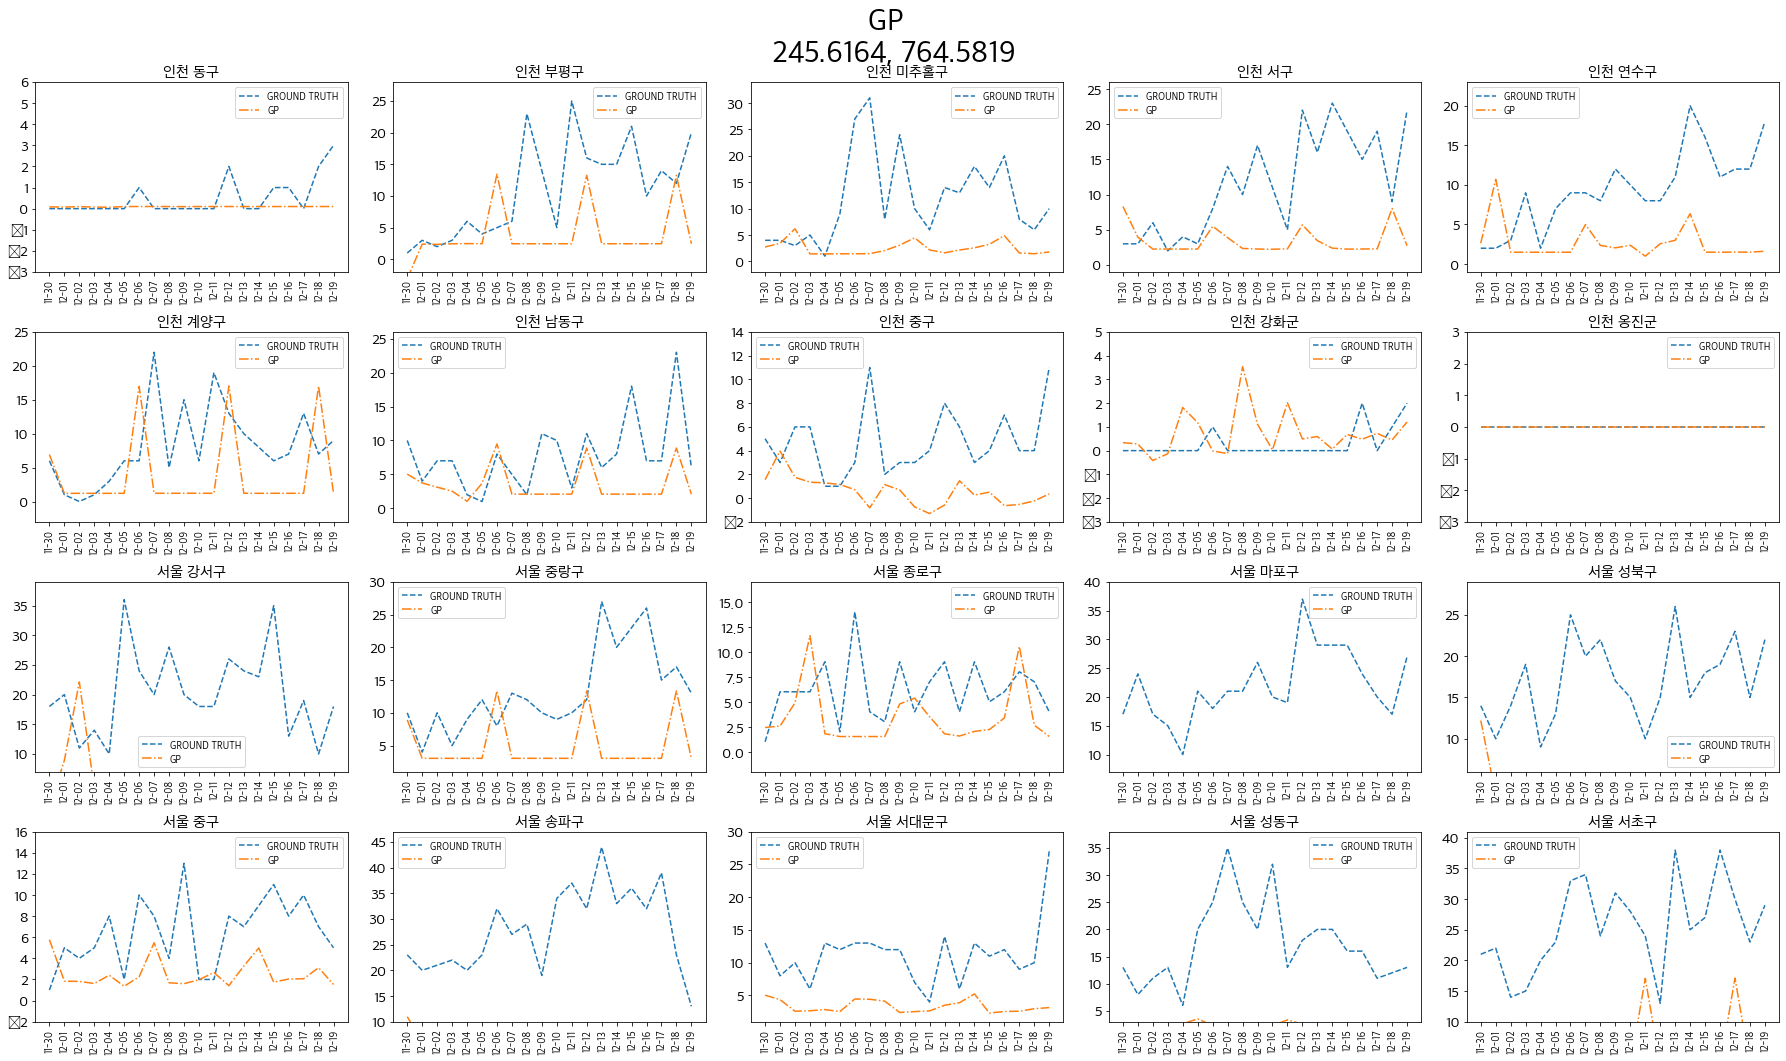

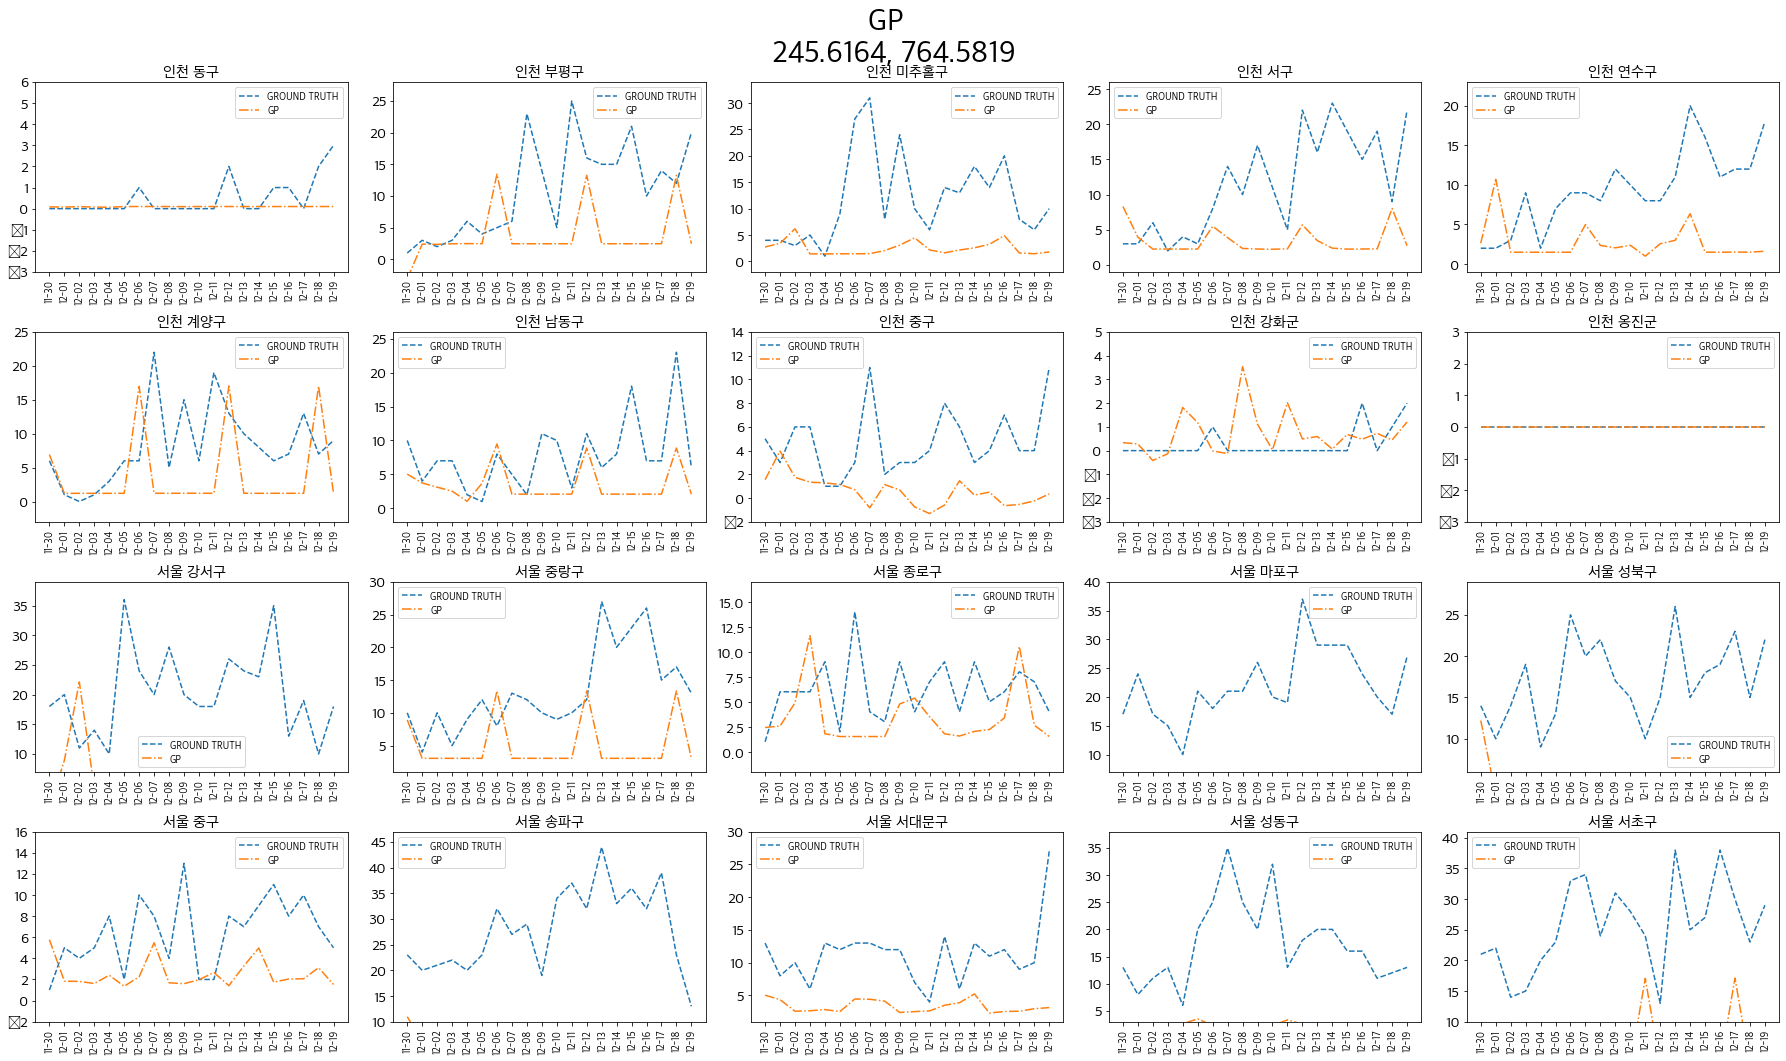

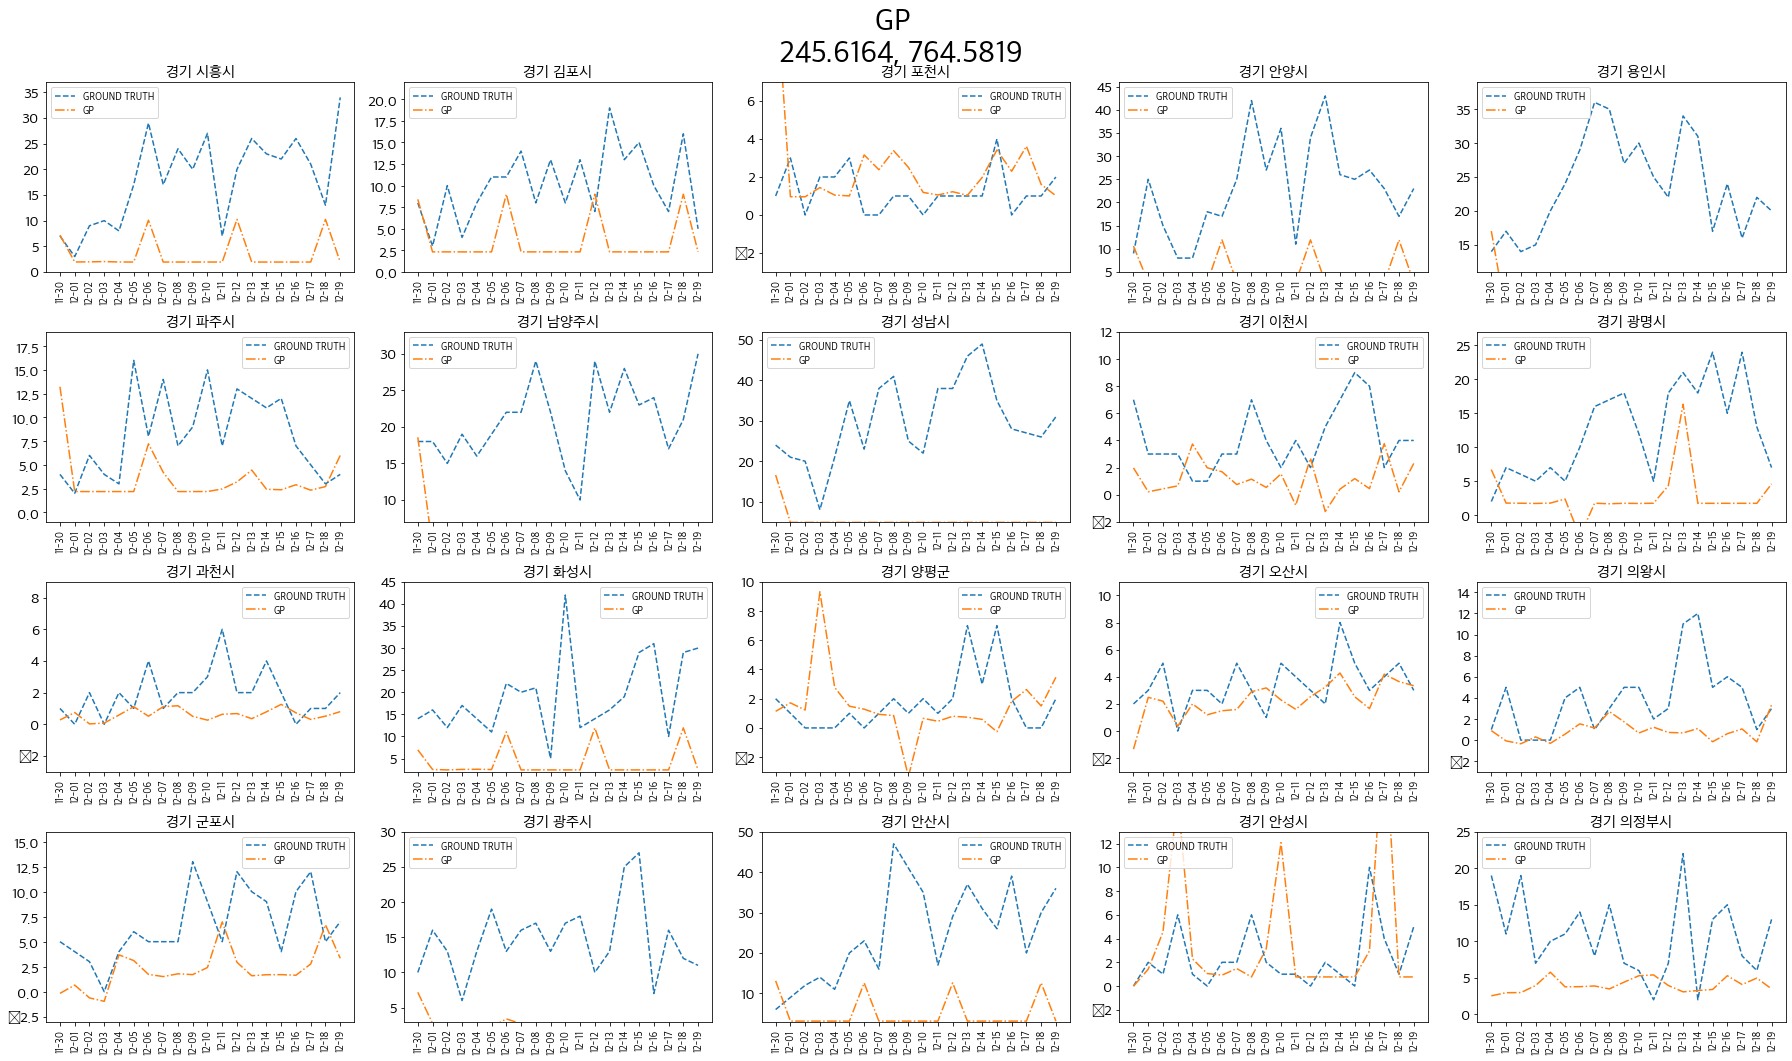

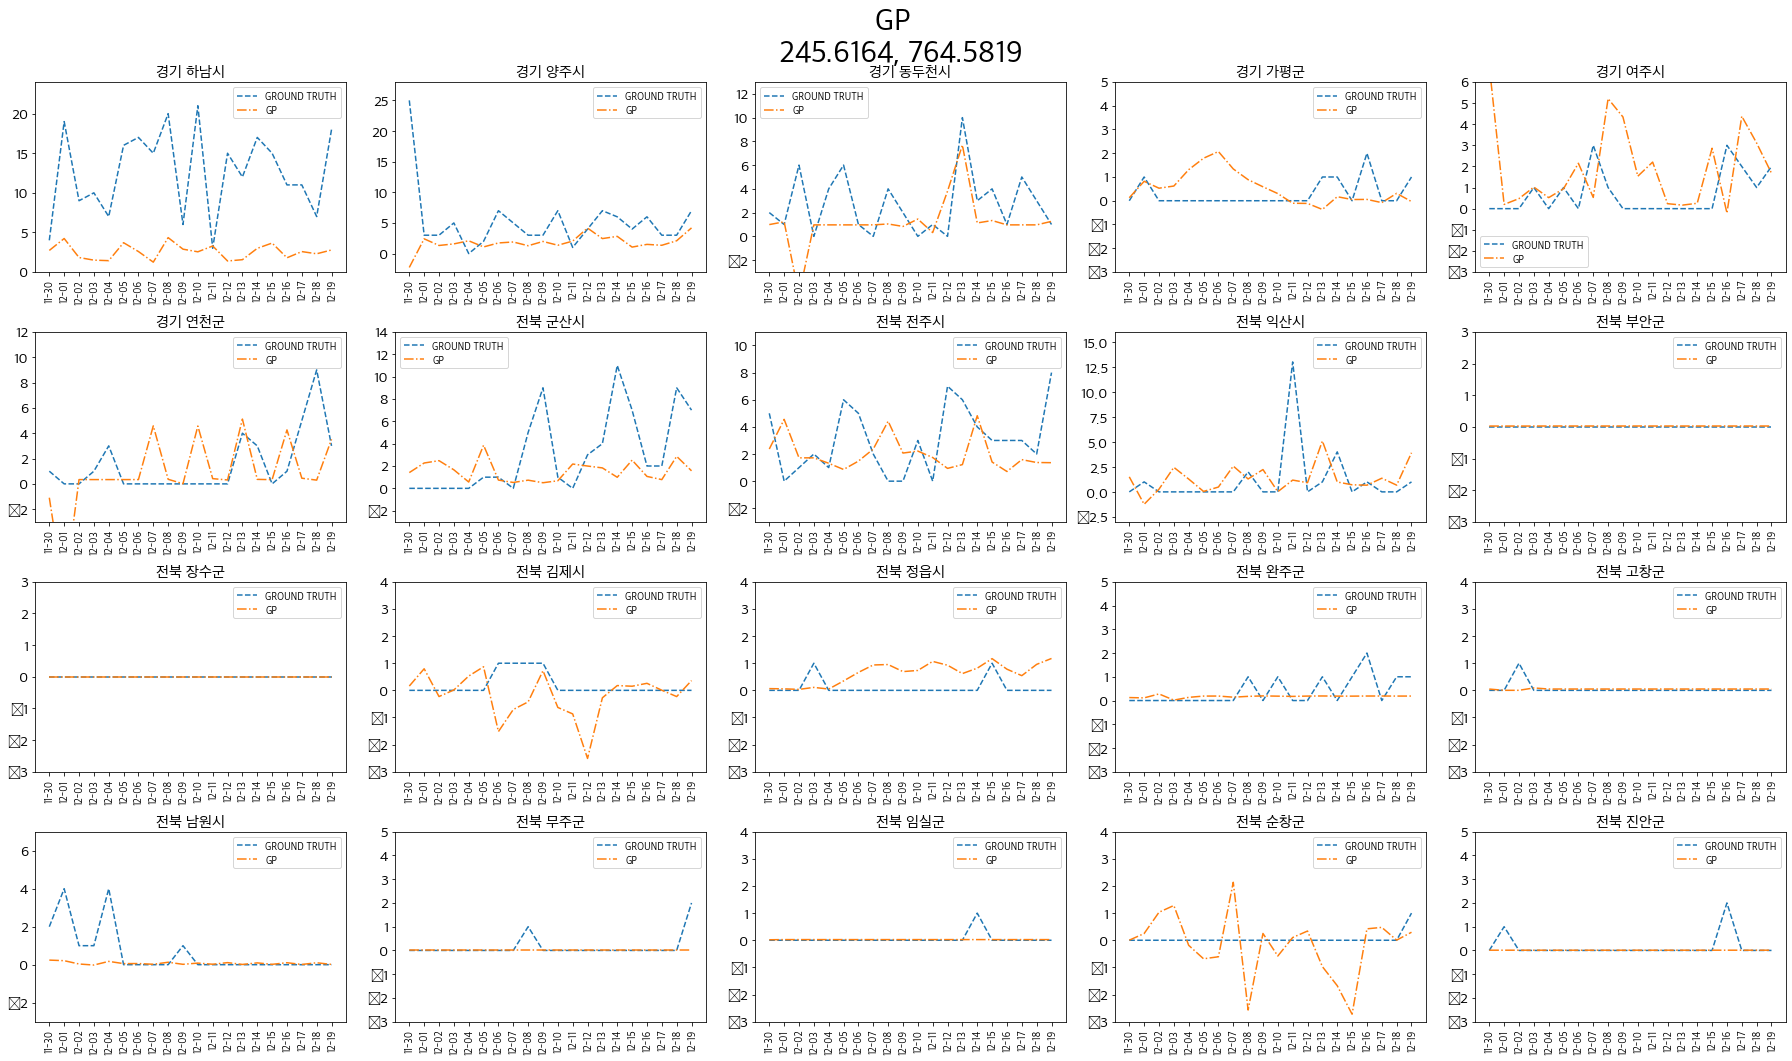

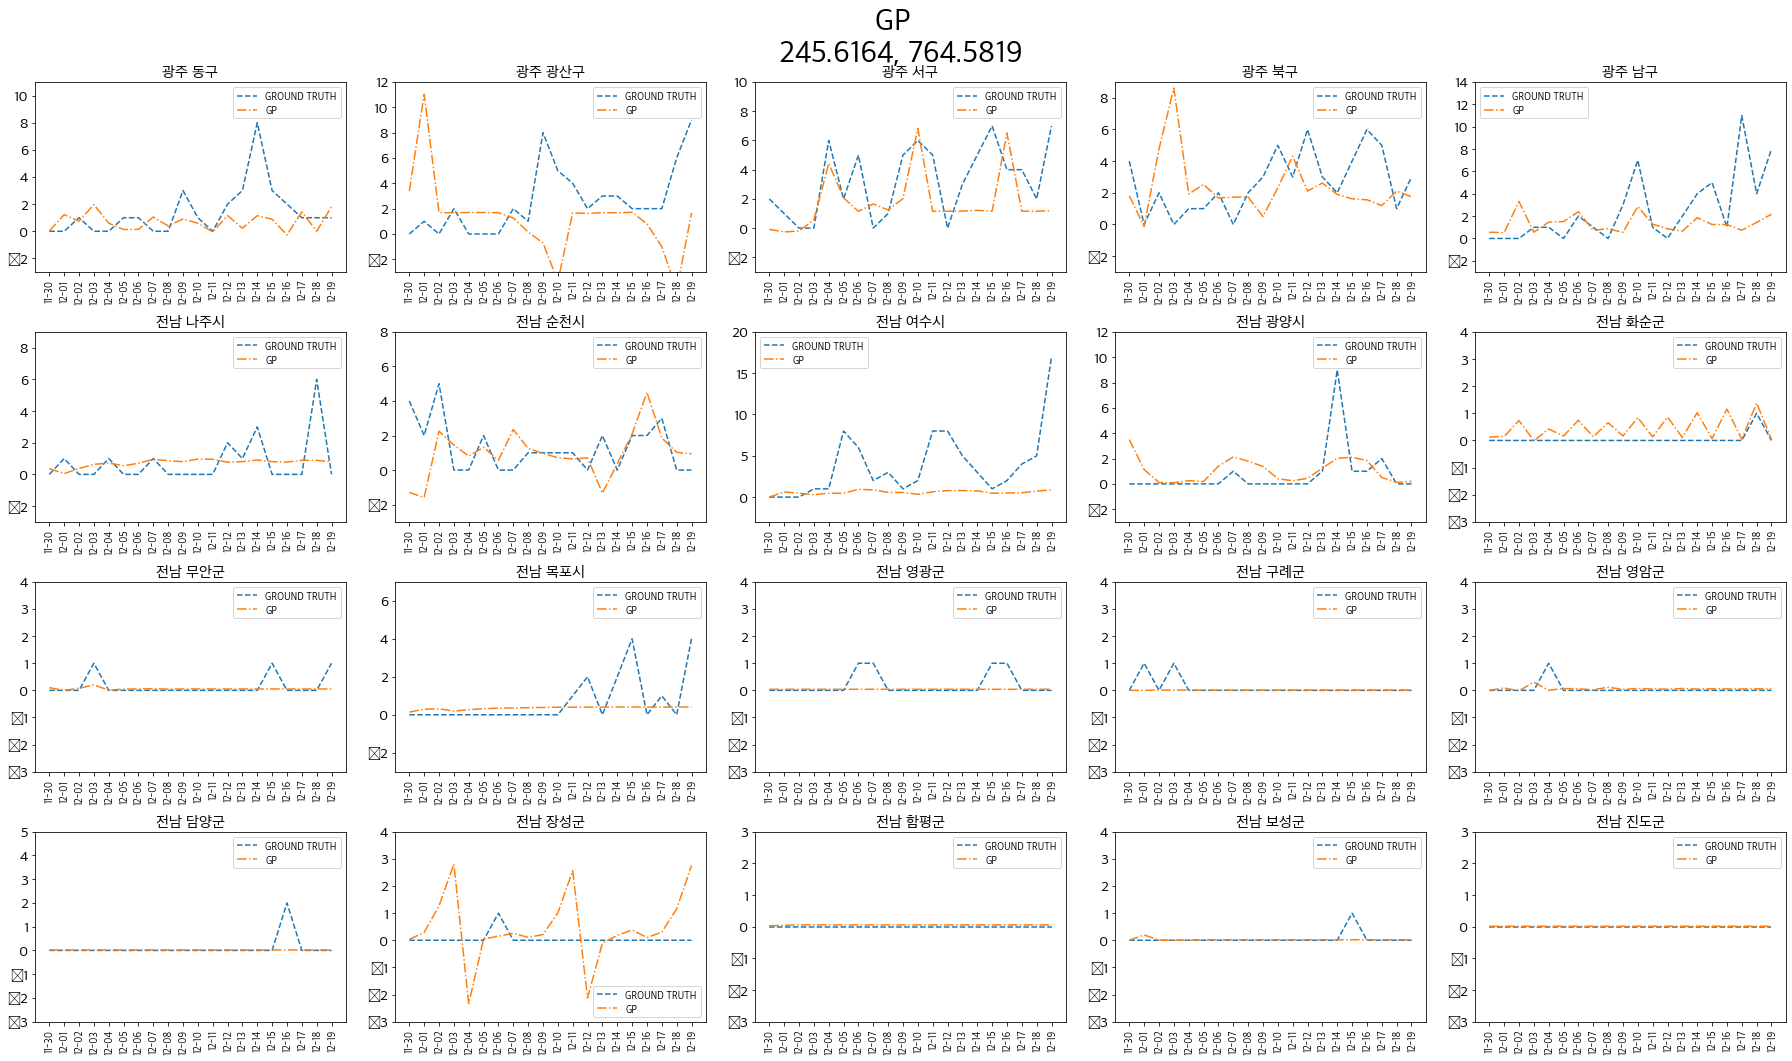

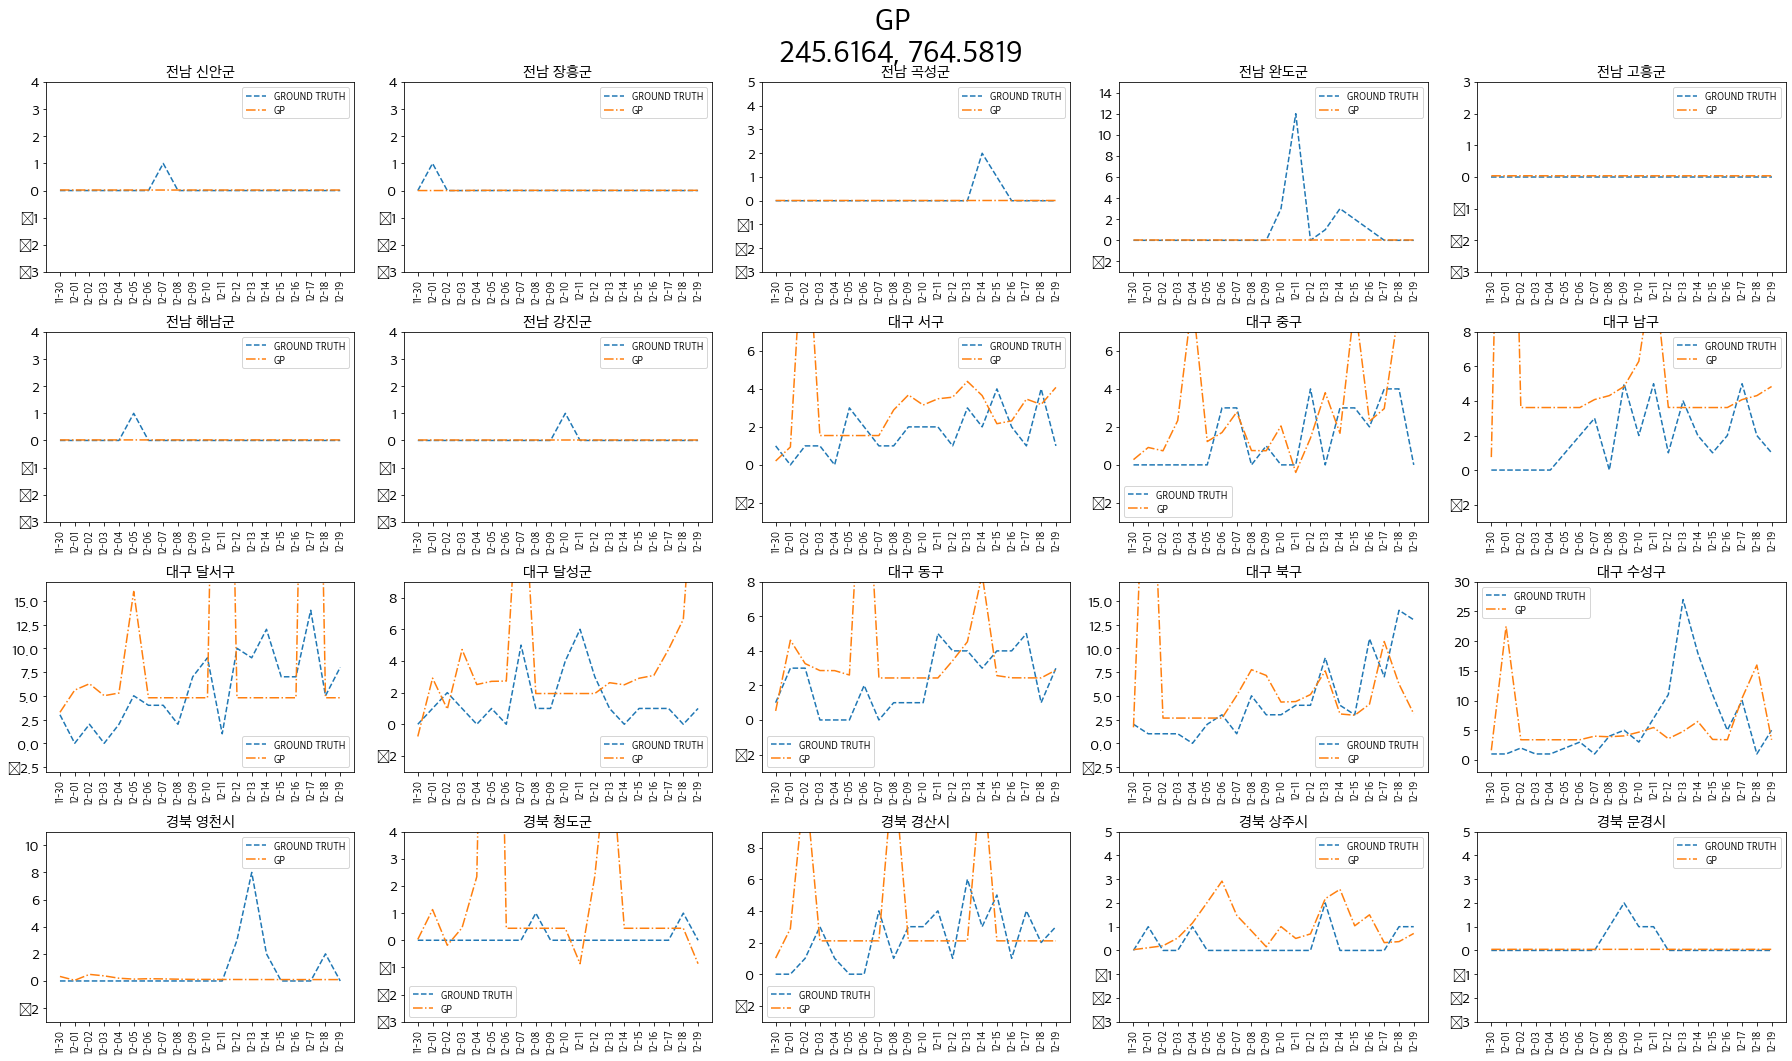

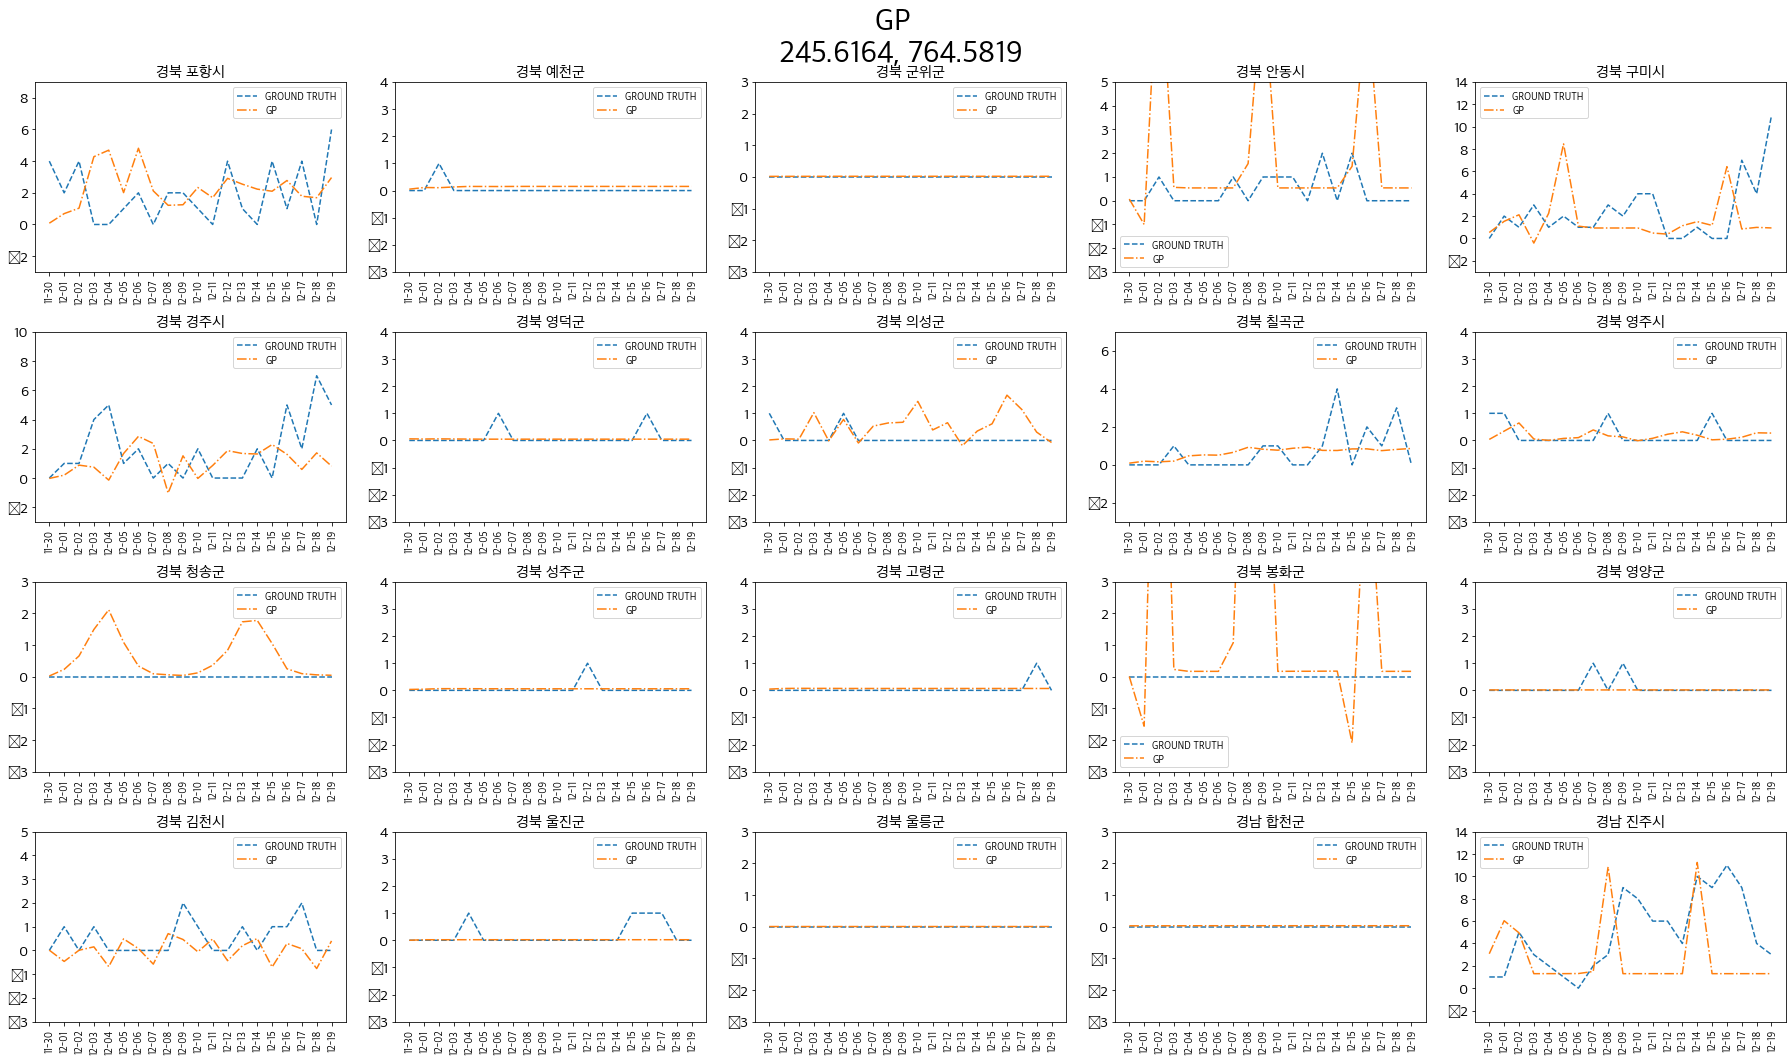

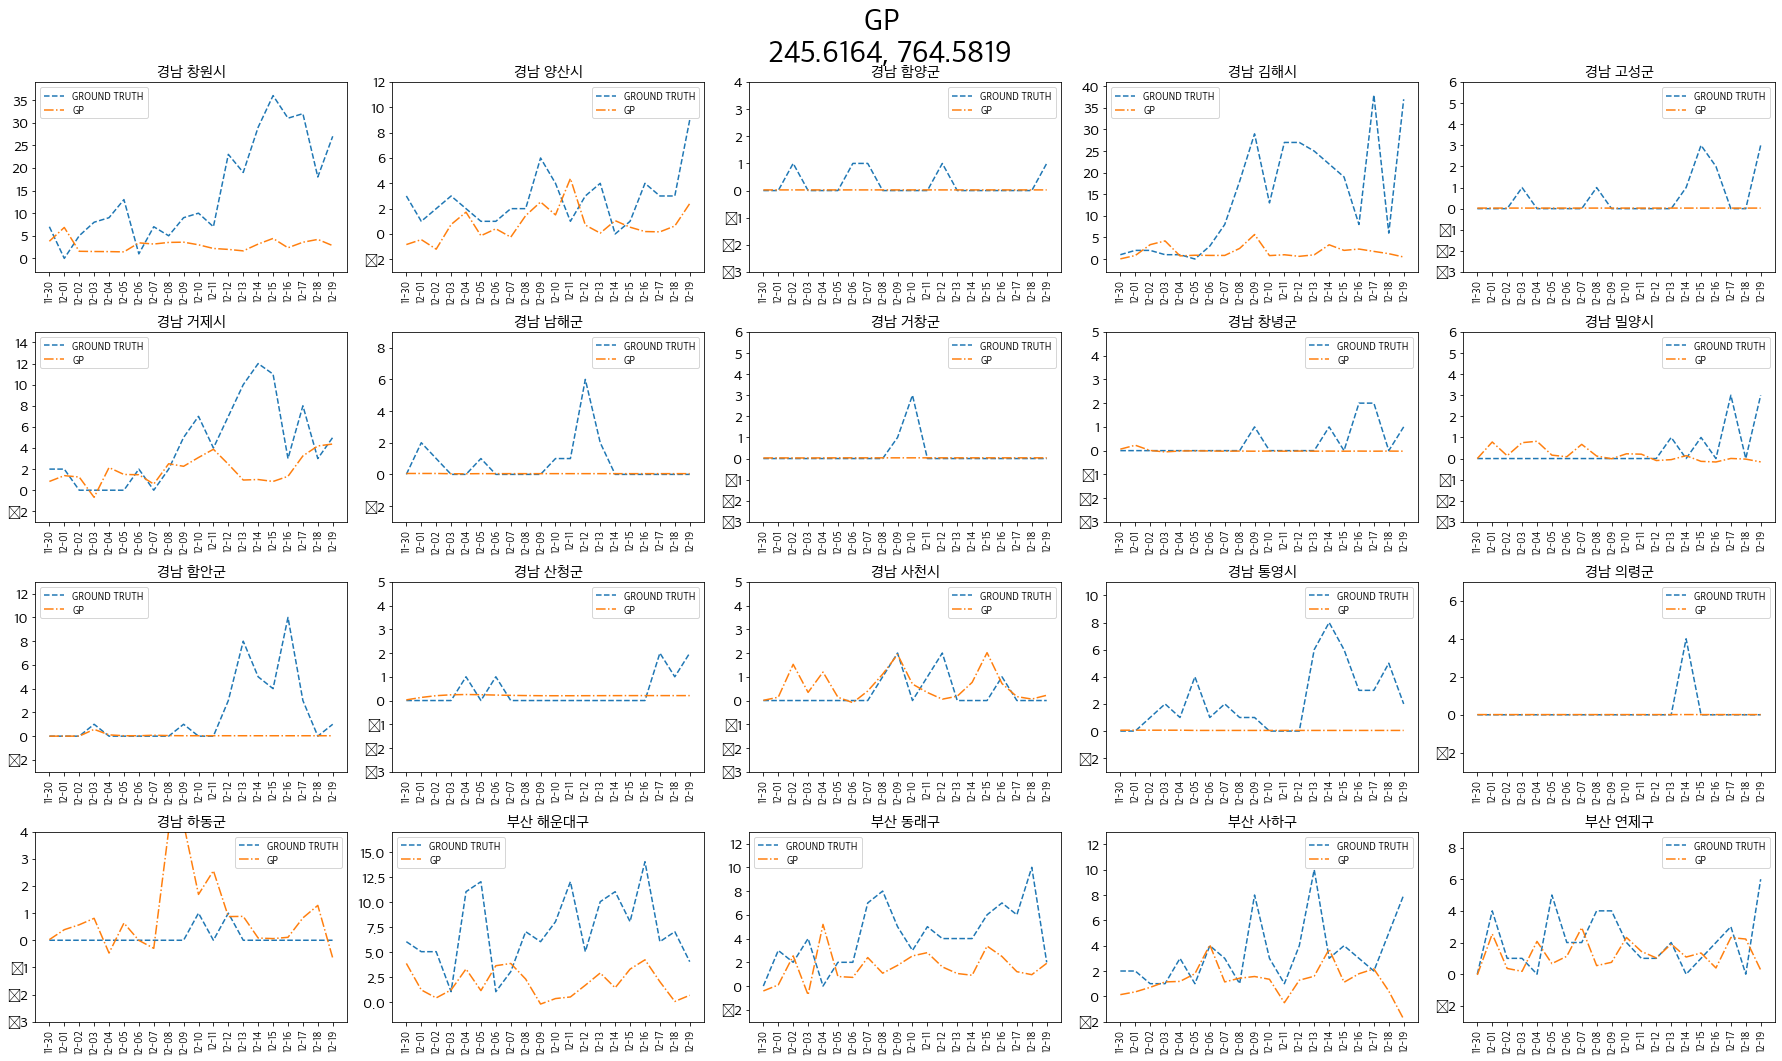

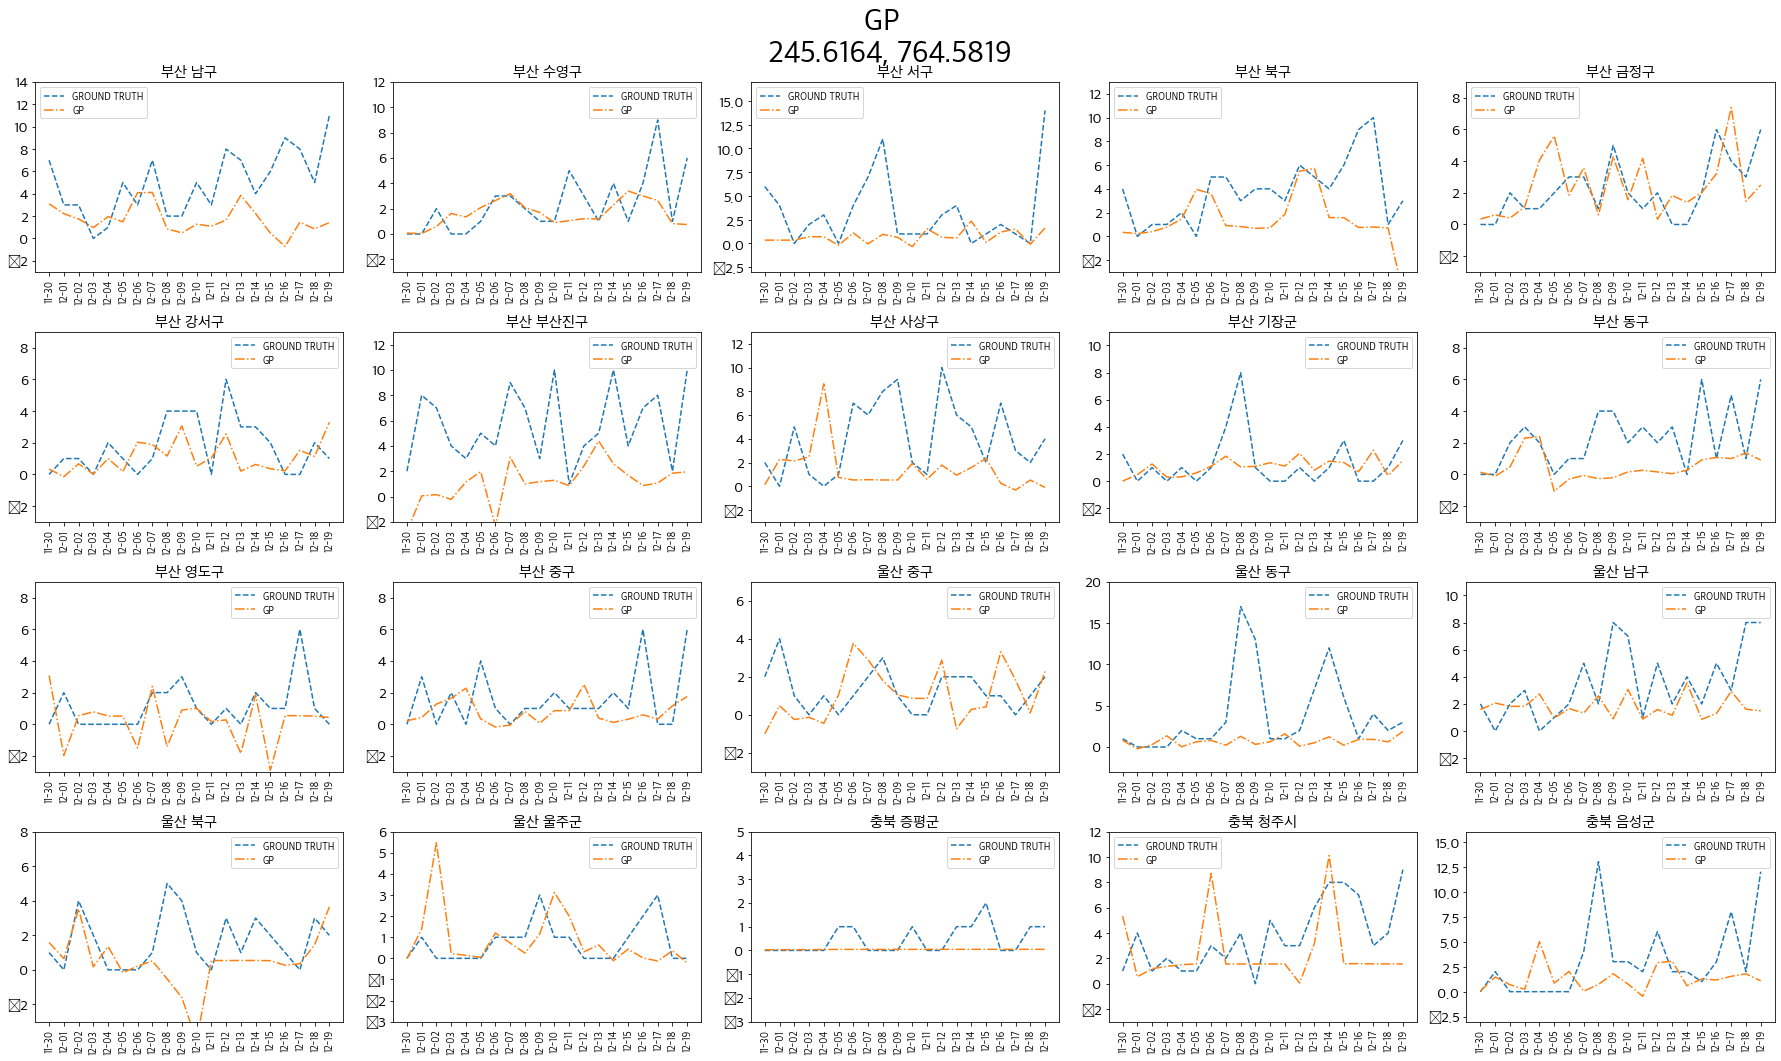

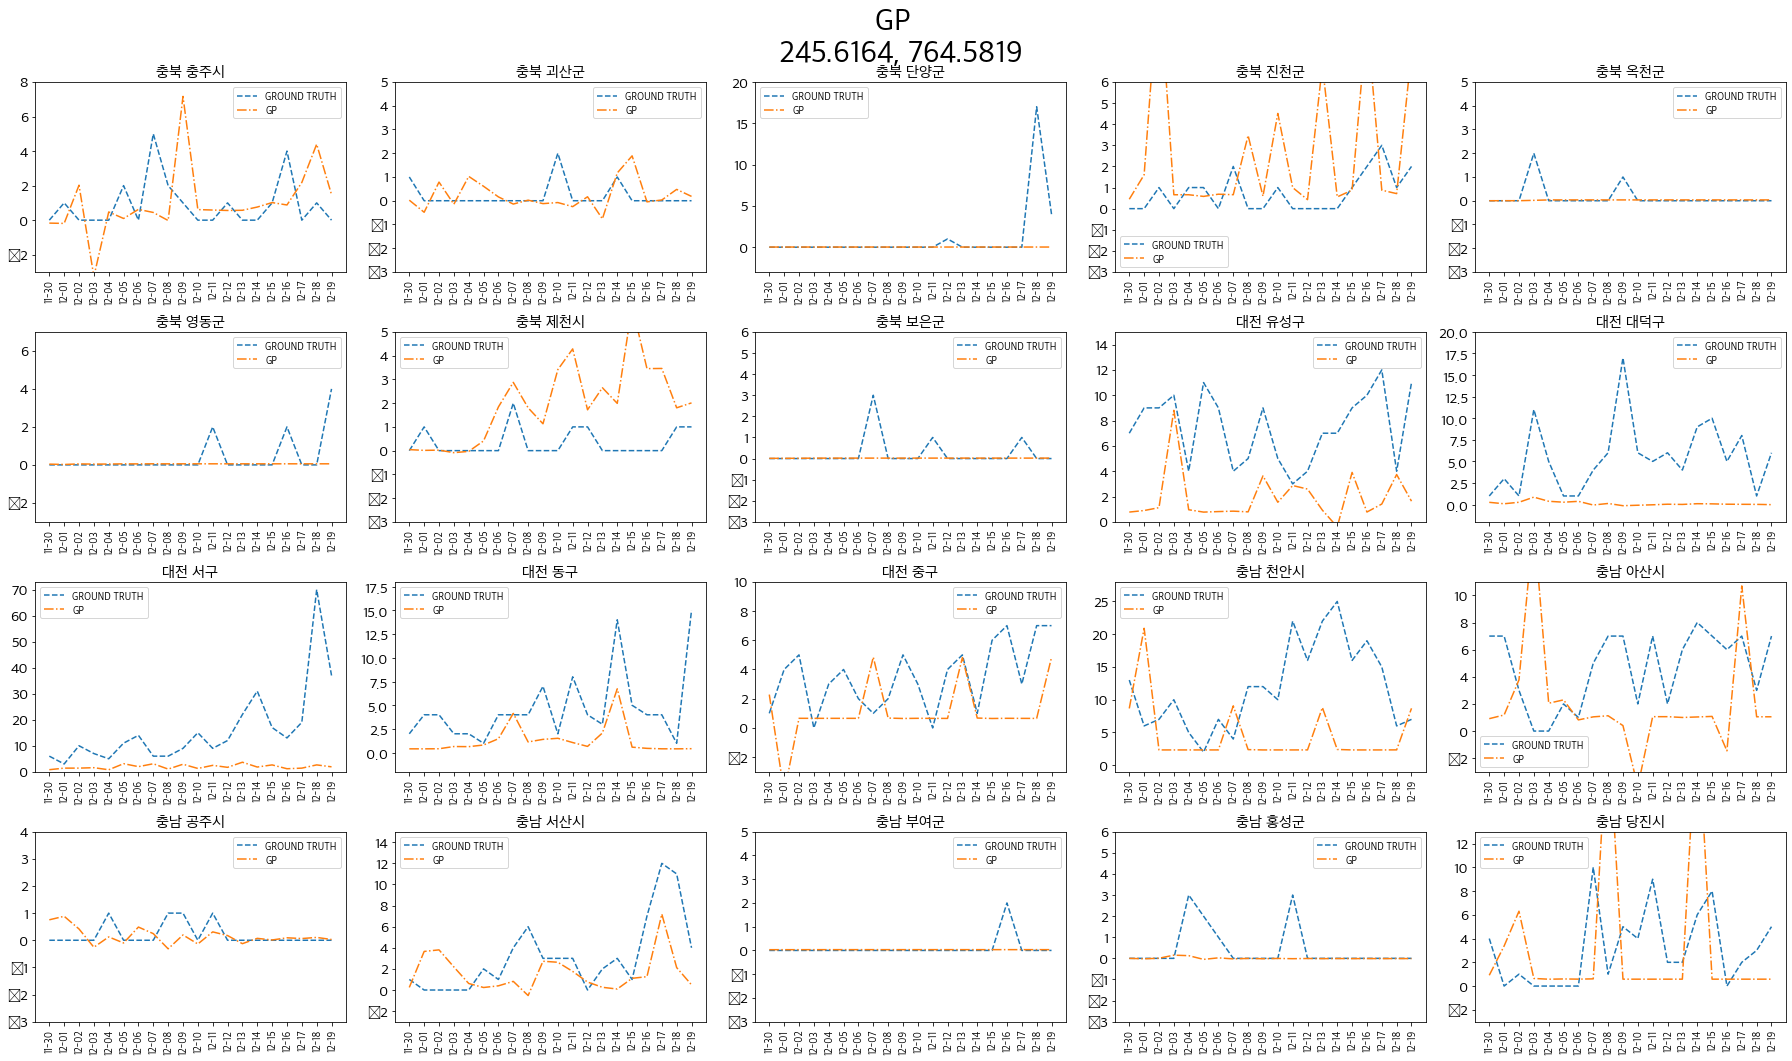

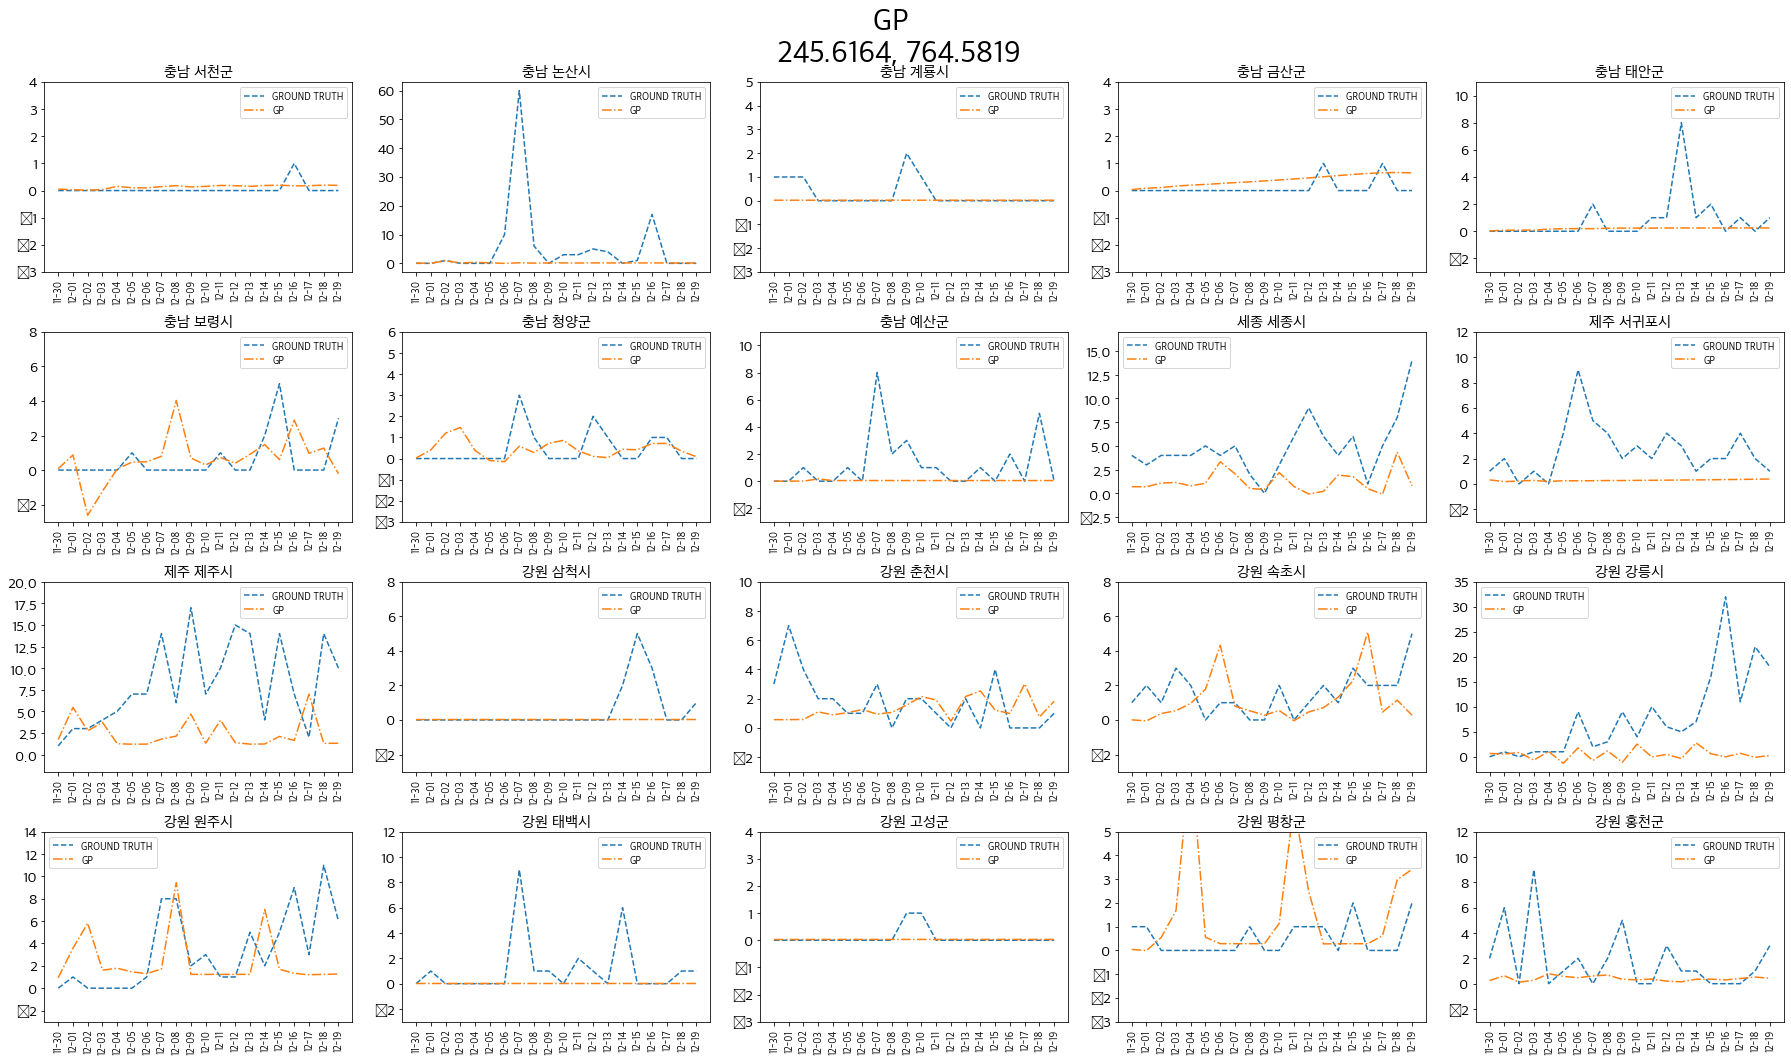

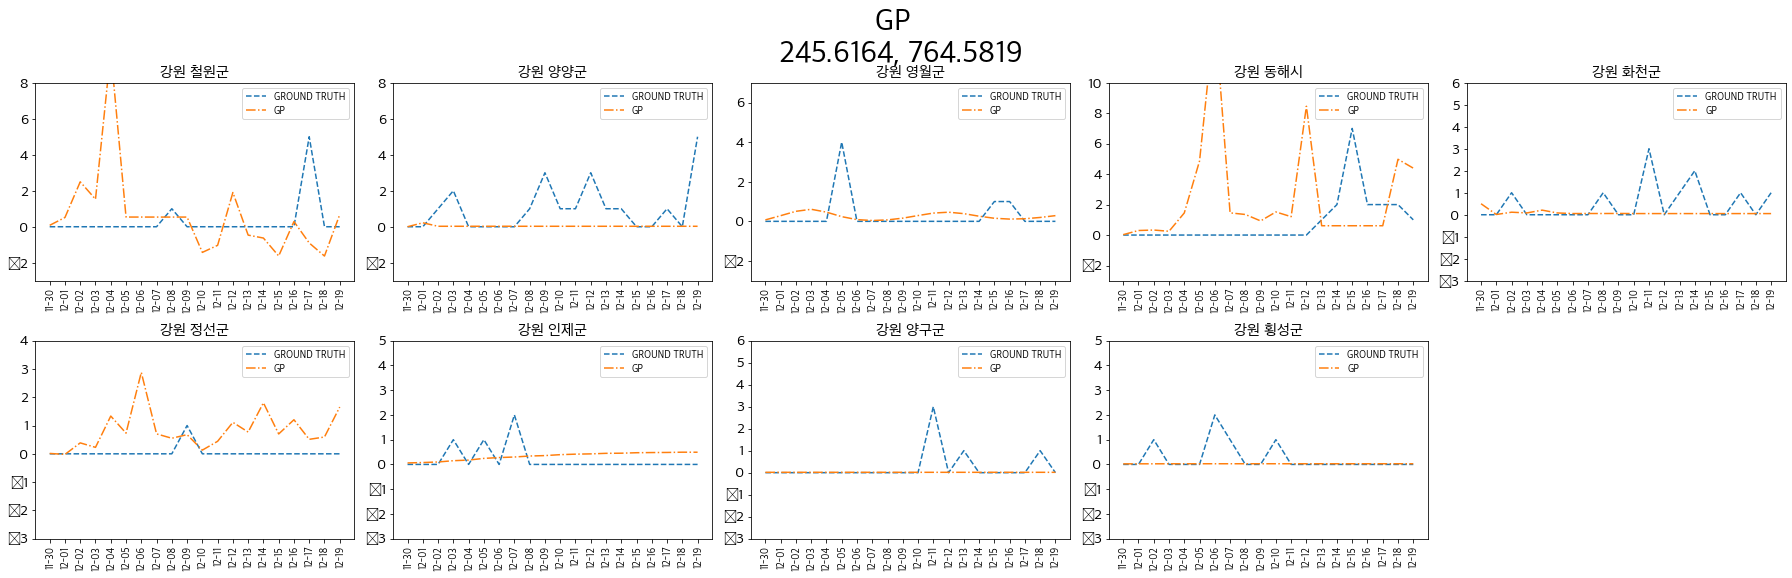

In [9]:
from lib import save_figure_predict
gt_mul_list.index = df[df.index >= '2021-11-30'].index[:20]
pred_mul_list.index = df[df.index >= '2021-11-30'].index[:20]
# GROUND_TRUTH = df.diff().iloc[-horizon:,]# + df.iloc[-(horizon+1):-1,].values
# PRED = y_pred# + df.iloc[-(horizon+1):-1,].values

suptitle = f"{MODEL_NAME}"
save_figure_predict(
                    GROUND_TRUTH = gt_mul_list,
                    y_pred = [pred_mul_list],
                    # test_data = None,
                    region_dict = region_dict,
                    suptitle = suptitle,
                    legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data'],
                    date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
                    MAE = MAE_LSTM_list, RMSE = RMSE_LSTM_list,
                    MAE_total = MAE_total, RMSE_total = RMSE_total, 
                    PATH=Figure_path
                    )

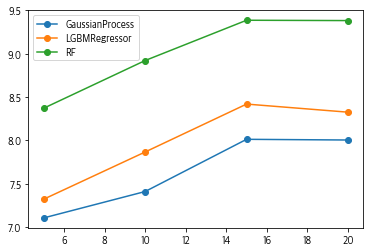

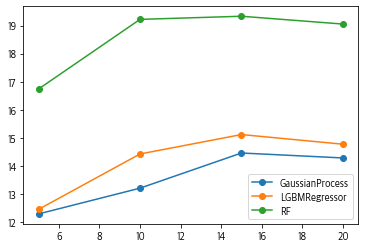

In [ ]:
import matplotlib.pyplot as plt
# gpr_mae = [7.107073195711559, 7.4113178223999014, 8.013594657446305, 8.00558656297911]
# gpr_rmse = [12.280451154821934, 13.199618433388705, 14.454355192685922, 14.277592739628027]

lgbm_mae = [7.322851043946682, 7.8673458181991345, 8.419999376323656, 8.326557793405637]
lgbm_rmse = [12.442720576092213, 14.419308959829623, 15.11247173219228, 14.768118136766981]

rf_mae = [8.372014783176297, 8.922156323460635, 9.386886599399148, 9.382971707035722]
rf_rmse = [16.737602398005272, 19.222847023307896, 19.33468251201428, 19.05546216179487]

plt.plot([5, 10, 15, 20], gpr_mae, '-o')
plt.plot([5, 10, 15, 20], lgbm_mae, '-o')
plt.plot([5, 10, 15, 20], rf_mae, '-o')
plt.legend(['GaussianProcess', 'LGBMRegressor', 'RF'])
plt.show()

plt.plot([5, 10, 15, 20], gpr_rmse, '-o')
plt.plot([5, 10, 15, 20], lgbm_rmse, '-o')
plt.plot([5, 10, 15, 20], rf_rmse, '-o')
plt.legend(['GaussianProcess', 'LGBMRegressor', 'RF'])
plt.show()

In [ ]:
##################
## Load Dataset ##
##################

region_type = 'city'
df2 = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')

# df = df2.iloc[100:533] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 
df2 = df2.iloc[:850] #340 326 319
df = df2.diff()
df = df.dropna()

############################################
## train, test, validation length setting ##
############################################

# split_date = '2020-11-23'
# split_date = '2021-06-25'
split_date = '2021-11-25'
val_ratio = 0.2

train_df = df[df.index < split_date]
test = df.iloc[len(train_df):, :]

len_val = int(train_df.shape[0] * val_ratio)
len_train = train_df.shape[0] - len_val
train = train_df.iloc[:len_train,:]
val = train_df.iloc[len_train :, :]


### 컬럼을 숫자로 바꿔줌 ###
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region
# df.columns = list(region_dict.keys())

y_pred = pd.DataFrame({})
# fig = plt.figure(figsize=(25,15), facecolor='white')
gt_list = []
pred_list = []

############################
## Hyperparameter Setting ##
############################

diff_ = "1st"
suptitle_1 = 'Standard Scaler, LSTM'
epochs = 50
batch_size = 16
num_layers = 1
# hidden_size = 16
# output_size = 16
TIME_STEPS = 5
learning_rate = 1e-2
criterion = nn.MSELoss()

import shutil
MODEL_NAME = 'RNN'
tmp = ""
dataset_name = "RF_test"
horizon = len(test)-TIME_STEPS

result_dir = ('%s'+tmp) % (MODEL_NAME)
model_dir = ('%s'+tmp) % (MODEL_NAME)
Figure_path = os.path.join('Result', dataset_name, 'Figure', str(horizon), result_dir)
Diameter_path = os.path.join('Result', dataset_name, 'Diameter', str(horizon), result_dir)
Pred_path = os.path.join('Result', dataset_name, 'Pred', str(horizon), result_dir)
model_path = os.path.join('Save_model', dataset_name, str(horizon), model_dir)


if os.path.exists(Figure_path):
    shutil.rmtree(Figure_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Diameter_path):
    shutil.rmtree(Diameter_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Pred_path):
    shutil.rmtree(Pred_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(model_path):
    shutil.rmtree(model_path) # 해당 경로 데이터 모두 삭제
    
os.makedirs(Figure_path) # 새로 폴더 생성
os.makedirs(Diameter_path) # 새로 폴더 생성
os.makedirs(Pred_path) # 새로 폴더 생성
os.makedirs(model_path) # 새로 폴더 생성

gt_list, pred_list = pd.DataFrame({}), pd.DataFrame({})
gt_5_list, pred_5_list = [], []
gt_10_list, pred_10_list = [], []
gt_15_list, pred_15_list = [], []
gt_mul_list, pred_mul_list = pd.DataFrame({}), pd.DataFrame({})
MAE_LSTM_list, RMSE_LSTM_list = [], []
# date_split = f"{df.index[0]} ~ {df.index[len_train]} ~ {df.index[len_train + len_val]} ~ {df.index[-1]}"
# print(date_split)
# for i in [0]:
for i, region in enumerate(df.columns):
# for i, region in enumerate(['인천 동구', '경기 시흥시']):
    
    #######################
    ## Define DataLoader ##
    #######################
    
    train = df[[region]][:len_train]
    val = df[[region]][ len_train: len_train + len_val]
    test = df[[region]][ len_train + len_val:]
    
    scaler = StandardScaler()

    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    x_train_seq, y_train_seq = seq_data(train, TIME_STEPS)
    x_val_seq, y_val_seq = seq_data(val, TIME_STEPS)
    x_test_seq, y_test_seq = seq_data(test, TIME_STEPS)
    # print(x_train_seq.shape, x_val_seq.shape, x_test_seq.shape)
    
    date_split = f"{df.index[0]} ~ {df.index[len(x_train_seq)-1]} ~ {df.index[len(x_train_seq)+TIME_STEPS + len(x_val_seq)+TIME_STEPS*2-1]} ~ {df.index[-1]}"
    print(date_split)
    
    # input(" stop ")
    # horizon = len(y_test_seq)
    train_torch = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    val_torch = torch.utils.data.TensorDataset(x_val_seq, y_val_seq)
    test_torch = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_torch, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_torch, batch_size=batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(dataset=test_torch, batch_size=batch_size, shuffle=False)

    # save_path = f"save_model/lstm_smooth_3_{suptitle_2}_{i}.pt"
    
    ############################
    ## Define Model and Train ##
    ############################
    
    # model = model_selection(MODEL_NAME='LSTM', TIME_STEPS=TIME_STEPS, device=device, save_path=model_path)
    model = RandomForestRegressor()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    trainer = RNNTrainer(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        test_loader=torch.tensor(x_test_seq, dtype=torch.float32),
                        loss=criterion,
                        optimizer=optimizer,
                        scaler=scaler,
                        device=device,
                        save_path=model_path,
                        res_df = df)

    
    trainer.train(epochs)
    val_loss, epoch = trainer.train(epochs)
    pred = trainer.predict(diff_, horizon)
    pred_mul, gt_mul, idx_list = trainer.multi_step_ahead_predict(split_date = split_date,
                                                  TIME_STEPS = TIME_STEPS,
                                                  horizon = 30,
                                                  region = region,
                                                  y_test = torch.tensor(y_test_seq, dtype=torch.float32))


    #######################
    ## Calculate Metrics ##
    #######################
    
    ground_truth = df2.diff().loc[df[df.index >= split_date].index[TIME_STEPS:TIME_STEPS+horizon]]

    gt_list[region] = ground_truth.iloc[:,i].tolist()
    pred_list[region] = list(pred)

    # Metric of each region 
    y_pred[region] = pred
    gt_mul_list[region] = gt_mul
    pred_mul_list[region] = np.array(pred_mul[5:]).squeeze() # [[]] -> []
    
gt_list.index = ground_truth.index
pred_list.index = ground_truth.index
gt_mul_list.index = idx_list
pred_mul_list.index = idx_list

# Total Metric
RMSE, RMSE_total = compute_metrics(gt_list, pred_list, metric='rmse')
MAE, MAE_total = compute_metrics(gt_list, pred_list, metric='mae')

RMSE_20, RMSE_total_5 = compute_metrics(gt_mul_list.iloc[:5], pred_mul_list.iloc[:5], metric='rmse')
MAE_20, MAE_total_5 = compute_metrics(gt_mul_list.iloc[:5], pred_mul_list.iloc[:5], metric='mae')

RMSE_10, RMSE_total_10 = compute_metrics(gt_mul_list.iloc[:10], pred_mul_list.iloc[:10], metric='rmse')
MAE_20, MAE_total_10 = compute_metrics(gt_mul_list.iloc[:10], pred_mul_list.iloc[:10], metric='mae')

RMSE_15, RMSE_total_15 = compute_metrics(gt_mul_list.iloc[:15], pred_mul_list.iloc[:15], metric='rmse')
MAE_20, MAE_total_15 = compute_metrics(gt_mul_list.iloc[:15], pred_mul_list.iloc[:15], metric='mae')

RMSE_20, RMSE_total_20 = compute_metrics(gt_mul_list.iloc[:20], pred_mul_list.iloc[:20], metric='rmse')
MAE_20, MAE_total_20 = compute_metrics(gt_mul_list.iloc[:20], pred_mul_list.iloc[:20], metric='mae')

#####################
## Save Prediction ##
#####################

# Save for Total Metric of Each Metric
pd.DataFrame({
              'MAE_LSTM' : MAE,
              'RMSE_LSTM' : RMSE
              }, index=df.columns).to_csv(f'{Pred_path}/RNN_region_metric.csv', encoding='cp949')

pd.DataFrame({'MAE_total' : MAE_total,
              'RMSE_total' : RMSE_total,
              'MAE_total_5' : MAE_total_5,
              'RMSE_total_5' : RMSE_total_5,
              'MAE_total_10' : MAE_total_10,
              'RMSE_total_10' : RMSE_total_10,
              'MAE_total_15' : MAE_total_15,
              'RMSE_total_15' : RMSE_total_15,
              'MAE_total_20' : MAE_total_20,
              'RMSE_total_20' : RMSE_total_20,  
              }, index=['LSTM']).to_csv(f'{Pred_path}/RNN_total_metric.csv', encoding='cp949')

gt_mul_list.to_csv(f'{Pred_path}/RNN_predict_20.csv', encoding='cp949')
pred_mul_list.to_csv(f'{Pred_path}/RNN_predict_20.csv', encoding='cp949')

y_pred['신고일'] = df2.index[-horizon:]
y_pred.set_index('신고일', inplace=True)
y_pred.to_csv(f'{Pred_path}/pred_LSTM_{region_type}.csv', encoding='cp949')

2020-01-20 ~ 2021-07-07 ~ 2021-11-29 ~ 2022-05-17


AttributeError: 'list' object has no attribute 'size'

In [ ]:
pd.DataFrame({'MAE_total' : MAE_total,
              'RMSE_total' : RMSE_total,
              'MAE_total_5' : MAE_total_5,
              'RMSE_total_5' : RMSE_total_5,
              'MAE_total_10' : MAE_total_10,
              'RMSE_total_10' : RMSE_total_10,
              'MAE_total_15' : MAE_total_15,
              'RMSE_total_15' : RMSE_total_15,
              'MAE_total_20' : MAE_total_20,
              'RMSE_total_20' : RMSE_total_20,  
              }, index=['LSTM'])

MAE_total  RMSE_total  MAE_total_5  RMSE_total_5  MAE_total_10  \
LSTM     44.543  223.754318     1.916343      4.142653      2.328384   

      RMSE_total_10  MAE_total_15  RMSE_total_15  MAE_total_20  RMSE_total_20  
LSTM       5.337789      2.668368       6.148017       2.88422       6.491193

### MAE, RMSE 다시 계산하는 코드 짜야함 test_data 25~26일 정도 구간으로 해서

In [ ]:
from lib import save_figure_predict

GROUND_TRUTH = df.diff().iloc[-horizon:,]# + df.iloc[-(horizon+1):-1,].values
PRED = y_pred# + df.iloc[-(horizon+1):-1,].values

suptitle = f"{MODEL_NAME}"
save_figure_predict(
                    GROUND_TRUTH = GROUND_TRUTH,
                    y_pred = pred_10_list,
                    # test_data = None,
                    region_dict = region_dict,
                    suptitle = suptitle,
                    legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data'],
                    date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
                    MAE = MAE_LSTM_list, RMSE = RMSE_LSTM_list,
                    MAE_total = MAE_total, RMSE_total = RMSE_total, 
                    PATH=Figure_path
                    )

# GROUND_TRUTH = df.diff().iloc[-horizon:,] + df.iloc[-(horizon+1):-1,].values
# PRED = y_pred + df.iloc[-(horizon+1):-1,].values
# suptitle = f"{MODEL_NAME}_{diff_}"
# save_figure_predict(

#                     df = GROUND_TRUTH,
#                     y_pred = PRED,
#                     test_data = None,
#                     region_dict = region_dict,
#                     suptitle = suptitle,
#                     legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data'],
#                     date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
#                     MAE = MAE_LSTM_list, RMSE = RMSE_LSTM_list,
#                     MAE_total = MAE_total, RMSE_total = RMSE_total, 
#                     PATH=Figure_path
#                     )

NameError: name 'pred_10_list' is not defined